In [1]:
import control as ct
from control.matlab import lsim
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Modelo de Suspensão de 1/4 do veículo

In [2]:
Susp = lambda K_m, M_1, M_2: [
    np.array([[0, 0, 1, 0],
              [0, 0, 0, 1],
              [-K_m/M_1, 0, 0, 0],
              [0, 0, 0, 0]]), 
    np.array([0, 0, K_m/M_1, 0]).reshape(4,1),
    np.array([0, 0, -1/M_1, 1/M_2]).reshape(4,1),
    np.eye(4),
    np.zeros(shape=(4,1))
]

In [3]:
K_m = 1000
M_1 = 70
M_2 = 258

[A, Bu, Bw, C, D] = Susp(K_m, M_1, M_2)
suspSys = ct.ss(A, Bu, C, D)

In [4]:
def suspDynamics(t, x, A, Bu, Bw):
    # controller
    u = 0

    # noise
    w = np.sin(25.13*t)
    
    xdot = np.matmul(A, x.reshape(4,1)) + Bu * u + Bw * w

    return xdot.flatten()


In [5]:
x0 = np.zeros(4)
result = solve_ivp(suspDynamics, (0,10), x0, args=(A, Bu, Bw))

t = result.t
x = result.y

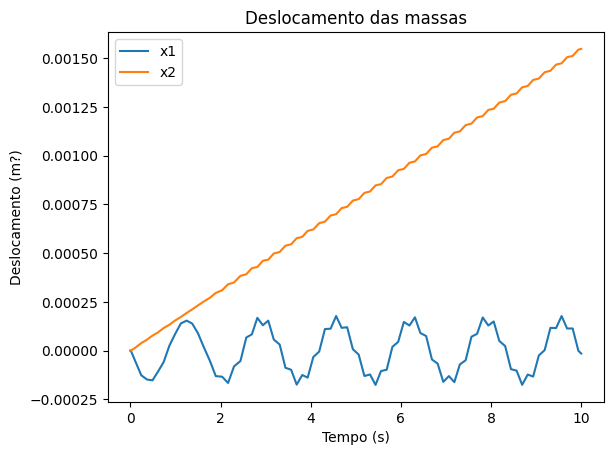

In [6]:
plt.figure(1)
plt.title("Deslocamento das massas")
plt.plot(t, x[0,:], label="x1")
plt.plot(t, x[1,:], label="x2")
plt.ylabel("Deslocamento (m?)")
plt.xlabel("Tempo (s)")
plt.legend()
plt.show()

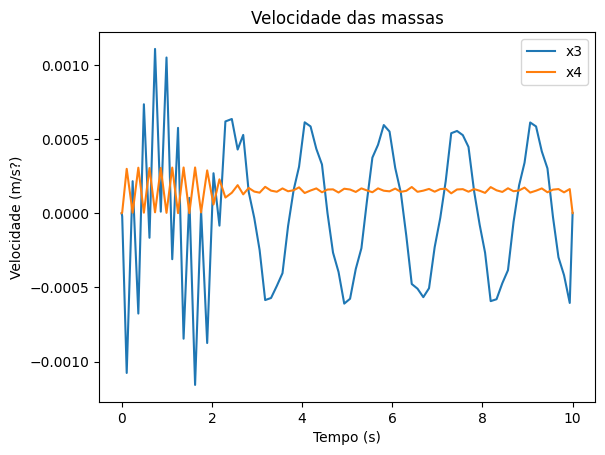

In [7]:
plt.figure(2)
plt.title("Velocidade das massas")
plt.plot(t, x[2,:], label="x3")
plt.plot(t, x[3,:], label="x4")
plt.ylabel("Velocidade (m/s?)")
plt.xlabel("Tempo (s)")
plt.legend()
plt.show()

In [8]:
C = np.concat([Bu, np.matmul(np.linalg.matrix_power(A, 1), Bu), np.matmul(np.linalg.matrix_power(A, 2), Bu), np.matmul(np.linalg.matrix_power(A, 3), Bu)], axis=1)
print(f"Posto da Matrix de Controlabilidade: {np.linalg.matrix_rank(C)}")

Posto da Matrix de Controlabilidade: 2


# Controle de ângulo de arfagem TRMS

In [9]:
A_trms = np.array([
    [0, 1, 0],
    [-3.8813, -0.2014, 1.9899],
    [0, 0, -0.9091]
])
B_trms = np.array([0, 0, 0.6737]).reshape(3,1)
C_trms = np.eye(1,3)
D_trms = 0

In [10]:
trmsSS = ct.ss(A_trms, B_trms, C_trms, D_trms)
trmsGs = ct.ss2tf(trmsSS)
trmsGs

TransferFunction(array([8.88178420e-16, 1.77635684e-15, 1.34059563e+00]), array([1.        , 1.1105    , 4.06439274, 3.52848983]))

In [11]:
# PID Controller
[Kp, Ki, Kd] = [0.7645, -0.7411, -0.5673]

s = ct.tf('s')
Gc = Kp + Kd*s + Ki/s
Gc

TransferFunction(array([-0.5673,  0.7645, -0.7411]), array([1, 0]))

In [12]:
trmsTs = ct.feedback(Gc*trmsGs, 1)
trmsTs

TransferFunction(array([-5.03863617e-16, -3.28714833e-16, -7.60519901e-01,  1.02488536e+00,
       -9.93515421e-01]), array([ 1.        ,  1.1105    ,  3.30387284,  4.55337519, -0.99351542]))

In [13]:
step = 0.5
t1 = 0 + np.arange(0, int(50*1/step)) * step
t2 = t1[-1] + step + np.arange(0, int(50*1/step)) * step
T = np.append(t1, t2)

u1 = 0.4*np.ones(shape=(1, t1.shape[0]))
u2 = 0.6*np.ones(shape=(1, t2.shape[0]))
U = np.append(u1, u2)

T.shape, U.shape

((200,), (200,))

In [14]:
yout, T, xout = lsim(trmsGs, U=U, T=T);
youtTs, T, xoutTs = lsim(trmsTs, U=U, T=T);

c:\Users\luiza\Desktop\controlScripts\.venv\Lib\site-packages\control\timeresp.py:1083: UserWarning: return_x specified for a transfer function system. Internal conversion to state space used; results may meaningless.
  warnings.warn(
c:\Users\luiza\Desktop\controlScripts\.venv\Lib\site-packages\scipy\signal\_lti_conversion.py:74: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  num, den = normalize(num, den)   # Strips zeros, checks arrays


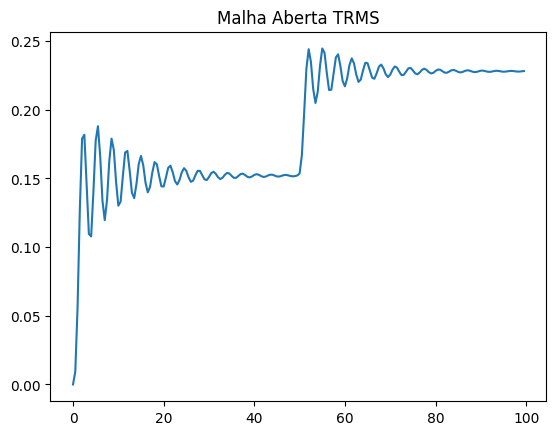

In [15]:
plt.figure(3)
plt.title("Malha Aberta TRMS")
plt.plot(T, yout)
plt.show()

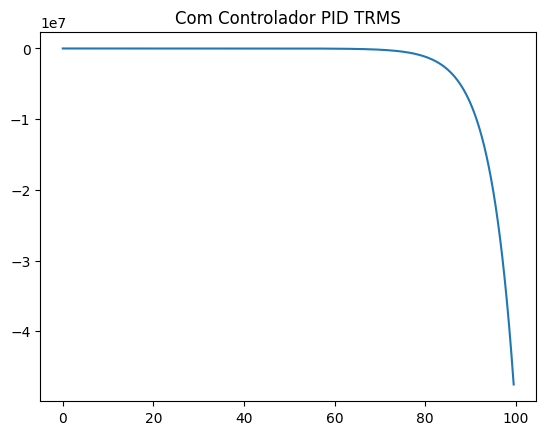

In [16]:
plt.figure(3)
plt.title("Com Controlador PID TRMS")
plt.plot(T, youtTs)
plt.show()